In [4]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [2]:


from binaural import Binaural
import sys
from binaural import Binaural
import numpy as np
from custom_timer import Timer
import data_generator_lib
import random
import pandas as pd
import multiprocessing as mp
import data_to_raw_numpy
import librosa
from librosa import display
import matplotlib.pyplot as plt
import gccphat
from simulation import Simulation
from IPython.display import HTML
from plotting import plotting
import constants

import final_models

import IPython.display as ipd


0it [00:00, ?it/s]Using TensorFlow backend.


===============================================================================


# Facing the Music
## Binaural Sound Localisation with Machine Learning

===============================================================================

# Let's synthesize some data!

## Get a sound source from the Google Speech Commands dataset

In [5]:
source = data_generator_lib.get_data(1)[5]

Text(0.5, 1.0, 'Mono Source Signal')

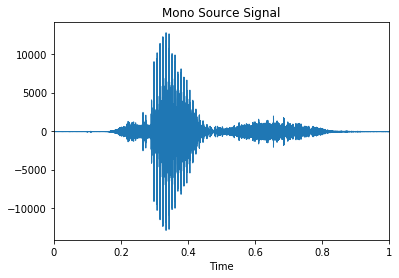

In [6]:
display.waveplot(source.data.astype('float64'),
                 source.fs)
plt.title('Mono Source Signal')

In [7]:
ipd.Audio(source.data, rate=source.fs) 

## Set up a room and record the audio 

In [8]:
# Set up constant parameters: room dim etc..
room = Binaural(room_dim=np.r_[4., 4., 4.],
             max_order=17,
             speed_of_sound=343,
             inter_aural_distance=0.2,
             mic_height=2)

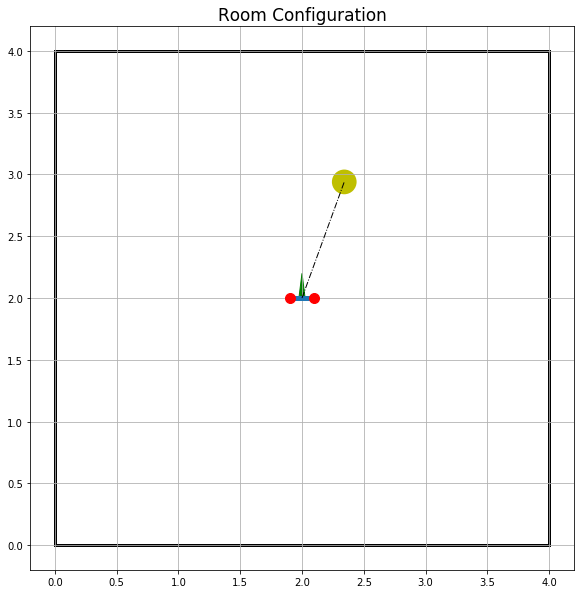

True Azimuth: 70.0


(array([-0.00659605,  0.08502627,  0.00261632, ..., -0.01295675,
        -0.07725619,  0.17034515]),
 array([-0.08960389, -0.03156173,  0.03526714, ...,  0.0340576 ,
        -0.01494404, -0.06475592]),
 70.0,
 '70.0.wav')

In [16]:
room.generate_impulse_pair(source_azimuth_degrees=70,
                           source_distance_from_room_centre=1,
                           SNR=0,
                           RT60=1,
                           mic_centre=np.array([2, 2]),
                           mic_rotation_degrees=0,
                           fs=source.fs,
                           source_signal=source.data,
                           plot_room=True,
                           plot_impulse=False,
                           write_wav=True,
                           wav_name="house_spatial_")

In [17]:
ipd.Audio("house_spatial_70.0.wav")

In [18]:
y, sr = librosa.load("house_spatial_70.0.wav", mono=False)

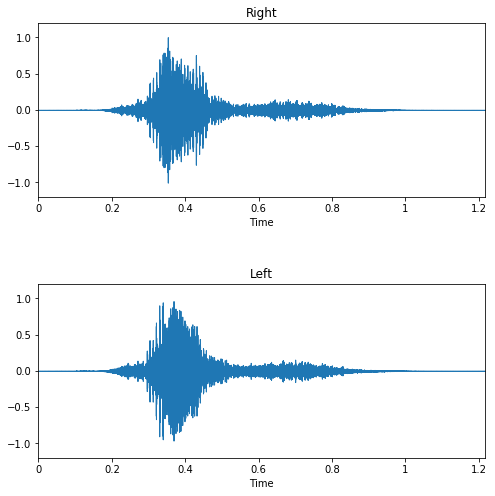

In [19]:
plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0.5)
plt.subplot(2,1,1)
plt.title("Right")
plt.ylim(-1.2,1.2)
display.waveplot(y[0],sr)
plt.subplot(2,1,2)
plt.title("Left")
plt.ylim(-1.2,1.2)
display.waveplot(y[1],sr)

## Generalised Cross-Correlation with Phase-Transfom

In [20]:
tau, gcc = gccphat.gcc_phat(y[1], y[0], fs=sr)

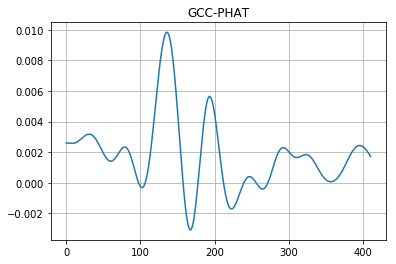

In [21]:
plt.plot(gcc)
plt.title("GCC-PHAT")
plt.grid()

In [22]:
theta = gccphat.tdoa(y[0], y[1], fs=sr)
print("Direction of Arrival: {doa} degrees".format(doa=np.round(theta,3)))

Direction of Arrival: 70.402 degrees


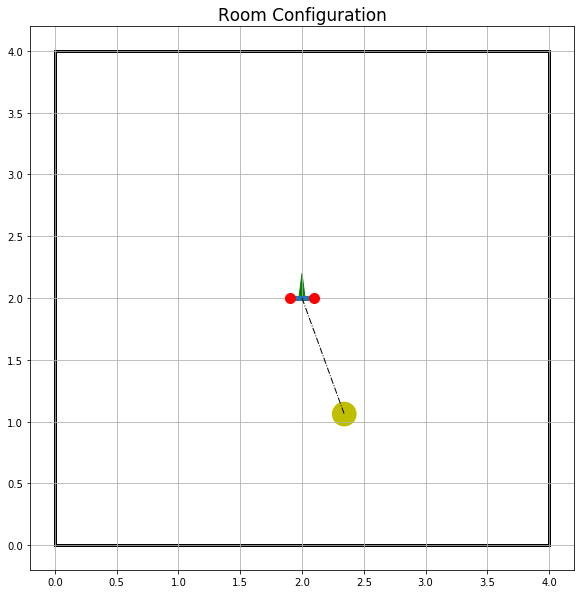

True Azimuth: 290.0
Direction of Arrival: 71.287 degrees


In [23]:
room.generate_impulse_pair(source_azimuth_degrees=290,
                           source_distance_from_room_centre=1,
                           SNR=0,
                           RT60=1,
                           mic_centre=np.array([2, 2]),
                           mic_rotation_degrees=0,
                           fs=source.fs,
                           source_signal=source.data,
                           plot_room=True,
                           plot_impulse=False,
                           write_wav=True,
                           wav_name="house_spatial_")

y_290, sr_290 = librosa.load("house_spatial_290.0.wav", mono=False)

theta_290 = gccphat.tdoa(y_290[0], y_290[1], fs=sr_290)
print("Direction of Arrival: {doa} degrees".format(doa=np.round(theta_290,3)))



## Front-Back Confusion


<img src="frontbackconfusion.png" width="512">

# How to fix this?

## Front back labelling

In [24]:
y_290 = librosa.resample(y_290, sr_290, 8000)

In [25]:
prediction = final_models.gcc_dsp().predict(y_290)
print("Possible Directions of Arrival: {doa} degrees".format(doa=prediction))

Model: gcc_dsp
Possible Directions of Arrival: [70.0, 290.0] degrees


##  Rotations!

<img src="rotationmodel_diagram.png" width="700">

# The full solution: GCC-PHAT + ConvNet + Rotations

In [26]:
%%capture

source_distance = 1
source_azimuth = 70



sim = Simulation(directory="simulation_test",
                 source_azimuth=source_azimuth,
                 source_distance=source_distance,
                 model="gcc_cnn")

prediction = sim.simulate()

plot = plotting(room_dim=constants.room_dim,
                source_distance=source_distance,
                source_azimuth=source_azimuth,
                mic_centre=sim.mic_centre,
                rotation_list=sim.rotation_list,
                prediction_list=sim.predictions,
                prediction=sim.prediction)

demo = plot.plot_room(notebook=True)

print("Final Prediction: {prediction}".format(prediction=prediction))


In [27]:
demo

In [215]:
%%capture




sim_290 = Simulation(directory="simulation_test",
                 source_azimuth=290,
                 source_distance=1,
                 model="gcc_cnn")

prediction_290 = sim_290.simulate()

plot_290 = plotting(room_dim=constants.room_dim,
                source_distance=1,
                source_azimuth=290,
                mic_centre=sim_290.mic_centre,
                rotation_list=sim_290.rotation_list,
                prediction_list=sim_290.predictions,
                prediction=sim_290.prediction)

demo_290 = plot_290.plot_room(notebook=True)

print("Final Prediction: {prediction}".format(prediction=prediction_290))

In [216]:
demo_290